# Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
import matplotlib.animation as animate
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets
import random

# Question 3

## Create dataset/loader and create the random seed

Random Seed:  4120


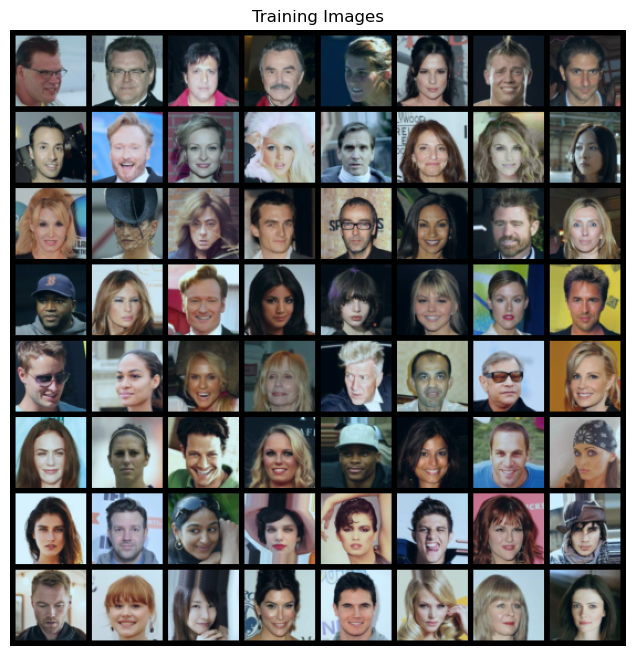

In [2]:
# seed = 393 # for same results
seed = random.randint(1, 10000) # for variation
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

img_size = 64
batch_size = 128
workers = 4
root="./data/CelebA"
nz = 100
# Size of feature maps in generator
gen_features = 64
# Size of feature maps in discriminator
disc_features = 64
# Number of training epochs
num_epochs = 1
# Learning rate for optimizers
D_lr = 0.002
G_lr = 0.001

dataset = datasets.ImageFolder(root=root,
                           transform=tf.Compose([
                               tf.Resize(img_size),
                               tf.CenterCrop(img_size),
                               tf.ToTensor(),
                               tf.Normalize(mean=(0.50612009, 0.42543493, 0.38282761), std=(0.26589054, 0.24521921, 0.24127836)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
grid_img = torchvision.utils.make_grid(real_batch[0])
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

## Setup weight function

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Setup and Initialization

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x nz x 1 x 1
            nn.ConvTranspose2d(in_channels=nz, out_channels=gen_features * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(gen_features * 8),
            nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*8) x 4 x 4
            # Paper uses kernel_size=5, stride=2 ==> cannot get 8x8 output
            nn.ConvTranspose2d(in_channels=gen_features * 8, out_channels=gen_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features * 4),
            # nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=gen_features * 4, out_channels=gen_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features * 2),
            # nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=gen_features * 2, out_channels=gen_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            # N x gen_features x 32 x 32
            nn.ConvTranspose2d(in_channels=gen_features, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # N x 3 x 64 x 64
        )
    
    def forward(self, x):
        return self.gen(x)

In [5]:
# Create the generator
netG = Generator().to(DEVICE)

netG.apply(weights_init)

print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

## Discriminator setup and initialization

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Nx3x64x64
            nn.Conv2d(in_channels=3, out_channels=disc_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1),
            # N x disc_features x 32 x 32
            self._step(in_channels=disc_features, out_channels=disc_features * 2, kernel_size=4, stride=2, padding=1),
            # N x (disc_features*2) x 16 x 16
            self._step(in_channels=disc_features * 2, out_channels=disc_features * 4, kernel_size=4, stride=2, padding=1),
            self._step(in_channels=disc_features * 4, out_channels=disc_features * 8, kernel_size=4, stride=2, padding=1),
            # N x (disc_features*8) x 4 x 4
            nn.Conv2d(in_channels=disc_features * 8, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
            # N x 1 x 1 x 1
        )
        
    def _step(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(),
            nn.LeakyReLU(0.1, inplace=True)
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
# Create the Discriminator
netD = Discriminator().to(DEVICE)

netD.apply(weights_init)

print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5

## Initialize Loss and Optimizers

In [8]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

real_label = 1.
fake_label = 0.

# Setup Adam optimizer for D and G
optimizerD = torch.optim.Adam(netD.parameters(), lr=D_lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=G_lr, betas=(0.5, 0.999))

## Training Loop

In [9]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] \tLoss_D: {lossD.item():.4f} \tLoss_G: {lossG.item():.4f} \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

        # save loss for plot
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # save G output on fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/1][0/1583] 	Loss_D: 1.9389 	Loss_G: 0.0054 	D(x): 0.3618 	D(G(z)): 0.3226/0.9947
[1/1][50/1583] 	Loss_D: 2.0078 	Loss_G: 3.9719 	D(x): 0.5728 	D(G(z)): 0.1172/0.0670
[1/1][100/1583] 	Loss_D: 1.7966 	Loss_G: 4.8704 	D(x): 0.8013 	D(G(z)): 0.6483/0.0214
[1/1][150/1583] 	Loss_D: 1.0107 	Loss_G: 2.2443 	D(x): 0.6656 	D(G(z)): 0.3240/0.1722
[1/1][200/1583] 	Loss_D: 1.0700 	Loss_G: 2.7194 	D(x): 0.5891 	D(G(z)): 0.2161/0.1431
[1/1][250/1583] 	Loss_D: 1.5566 	Loss_G: 1.0166 	D(x): 0.3323 	D(G(z)): 0.1381/0.4231
[1/1][300/1583] 	Loss_D: 1.2354 	Loss_G: 2.6069 	D(x): 0.6985 	D(G(z)): 0.4324/0.1294
[1/1][350/1583] 	Loss_D: 1.1985 	Loss_G: 2.2526 	D(x): 0.8029 	D(G(z)): 0.4995/0.1717
[1/1][400/1583] 	Loss_D: 0.9133 	Loss_G: 1.5177 	D(x): 0.7235 	D(G(z)): 0.2819/0.2728
[1/1][450/1583] 	Loss_D: 1.5814 	Loss_G: 1.7351 	D(x): 0.3210 	D(G(z)): 0.1007/0.2439
[1/1][500/1583] 	Loss_D: 1.0627 	Loss_G: 2.7073 	D(x): 0.6374 	D(G(z)): 0.3274/0.1183
[1/1][550/1583] 	Loss_D: 1.0872

## Visualise the loss

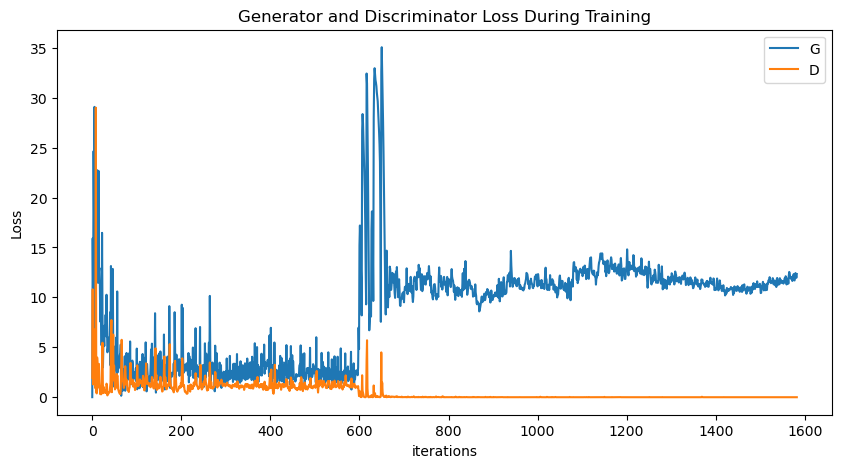

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Animate the generators progression

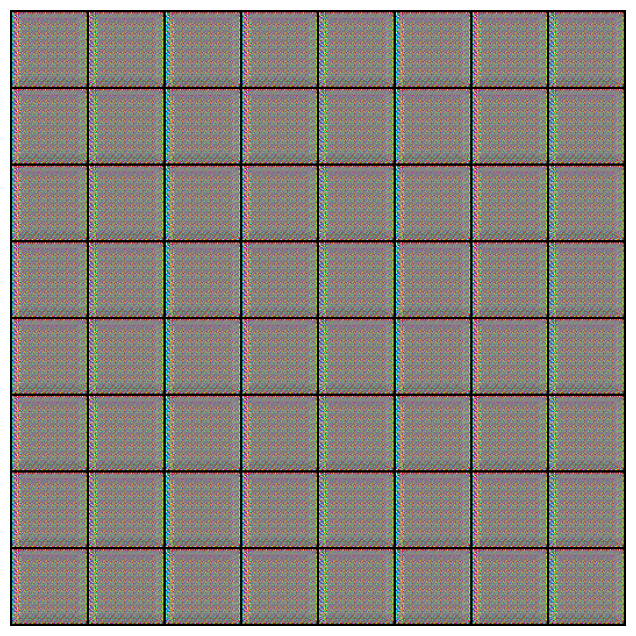

In [11]:
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animate.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())